In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 100

#HYPERPARAMETERS
preproc = 1


fit_level = 1

# lr = 0.03
max_counter = 200
max_Nepochs = 3500

In [3]:
# events = [50, 97, 71, 69, 48, 27]
# minev = [5.9, 4.3, 2.5, 2.2, 3.7,5.1]
events = [44.1, 92.7, 68.5, 66.8, 44.3, 21.9]
# events = [33.6, 59.5, 51.6, 84.1, 50.1, 19.6]
std_errev = [3.1,2.5,1.7,1.6,2.3,2.9]
# events, max_events, min_events, xvals_per_obs, binwidths, xlabels, events_per_obs, = read_LHEF_data()

sig_sys = std_errev
sig_sys = np.array(sig_sys)
sig_stat = np.sqrt(events)
xlabels = ['mu']
data = np.array(events) 

xvals_per_obs = [100.,300.,600.,1000.,-300.,-100.]
xvals_per_obs = np.array(xvals_per_obs)
xvals_per_obs /= 0.8


In [4]:
#Get errors
# sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)  
# xvals_per_obs = [100,300,600,-100,-300,1000] 
# xvals_per_obs = [100,300,600,100,-300,-100]  
# cov_matrix = np.array([
#     [9.2,-0.32,  0.08, -0.03,  0.00,  0.00],
#     [-0.32, 10.2, -0.43,  0.10, -0.01, -0.00],
#     [ 0.08, -0.43, 9.6, -0.31,  0.04, -0.02],
#     [-0.03,  0.10, -0.31, 22.3,-0.14,  0.01],
#     [ 0.00, -0.01,  0.04, -0.14, 12.1,-0.24],
#     [ 0.00, -0.00, -0.02,  0.01, -0.24,7.5]
# ])
# cov_matrix = np.array([
#     [5186, -1623,  340,  -69,    2,    5],
#     [-1623, 6239, -1952,  281,  -19,   -4],
#     [  340, -1952, 4165, -734,   56,  -27],
#     [  -69,   281, -734, 1738, -130,   15],
#     [    2,   -19,   56, -130,  622, -147],
#     [    5,    -4,  -27,   15, -147,  847]
# ])

cov_matrix = np.diag(sig_sys**2+sig_stat**2)
# sig_sys = np.array(sig_sys)
# sig_sys = np.sqrt(np.diag(cov_matrix)) 
# sig_stat = 0
# sig_stat = np.sqrt(data)
# np.fill_diagonal(cov_matrix, sig_stat**2 + sig_sys**2)
cov_matrix = np.linalg.inv(cov_matrix)
cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat,1)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [5]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

In [6]:
# print(data)
# print(level1)
# print(level2)
# plt.plot(xvals_per_obs,data)
# plt.xlabel(xlabels)
# plt.ylabel('N')
# plt.title("raw data")
# plt.show()

# for i in range(REPLICAS):
#     plt.plot(
#         xvals_per_obs, level2[i], 'o',label="level2"
#     )
#     plt.plot(
#         xvals_per_obs, level1[i], 'o',label="level1"
#     )
#     plt.plot(xvals_per_obs, data,'o',label="level0")
#     plt.xlabel(xlabels)
#     plt.legend()
#     plt.ylabel("N")
#     plt.title("level 2 data")
#     plt.show()


In [7]:
l1 = 3
l2 = 3
l3 = 3
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        # self.relu = torch.nn.ReLU()
        self.relu = torch.nn.Softplus()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [8]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            # self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            # self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))

        def forward(self, x):
            # alpha = (1 - 0.2)/2 *torch.tanh(self.alpha) + (1 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            # beta = torch.nn.functional.softmax(self.beta)
            return self.gamma * (1 - x) ** self.beta * x**(1-self.alpha) 
            # return 10 * (1 - x)**2 * x**(1.5) 
            # return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_NN
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix)
        return loss

In [10]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
xvals_per_obs= torch.tensor(xvals_per_obs, dtype=torch.float32).view(-1,1)
neutrino_pdfs_mu,neutrino_pdfs_mub,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[],[]

xvals_per_obs_mu = [100,300,600,1000]
xvals_per_obs_mub = [100,300,1000]
xvals_per_obs_mu = np.array(xvals_per_obs_mu)
xvals_per_obs_mub = np.array(xvals_per_obs_mub)
xvals_per_obs_mub= torch.tensor(xvals_per_obs_mub, dtype=torch.float32).view(-1,1)
xvals_per_obs_mu= torch.tensor(xvals_per_obs_mu, dtype=torch.float32).view(-1,1)

In [11]:
# x_alphas *=2
lr=0.03
max_counter = 100
max_ep = 10000
def perform_fit(pred,REPLICAS):

    
    
    for i in range(REPLICAS):
        if preproc == 1:
            alpha,beta,gamma = 1,1,10
            model_mu = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
            model_mub = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
        
            
                # model.load_state_dict(model_params)    

        criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
        optimizer_mu = torch.optim.Adam(model_mu.parameters(), lr=lr, weight_decay=1e-3)
        optimizer_mub = torch.optim.Adam(model_mub.parameters(), lr=lr, weight_decay=1e-3)
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.3)
        

        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        losses = []
        pred[i] = pred[i].squeeze()

        

        model_mu.train()
        best_loss = 1e13 # initial loss
        counter = 0
        # num_epochs = 4000
        num_epochs = 0
        # for ep in range(num_epochs):
        while counter < max_counter:  
            num_epochs +=1
            if num_epochs>max_ep:
                break
            
            # num_epochs+=1
            optimizer_mu.zero_grad()
            optimizer_mub.zero_grad()
            
            y_preds_mu =  model_mu(xvals_per_obs_mu)
            y_preds_mub =  model_mub(xvals_per_obs_mub)


            y_pred_mu = y_preds_mu.squeeze()
            y_pred_mub = y_preds_mub.squeeze()

            y_pred_mu[-1] = y_pred_mu[-1] + y_pred_mub[-1]
            
            y_pred_mub = y_pred_mub[:-1]

            y_pred_mub = torch.flip(y_pred_mub, dims=[0])
            
            y_preds = torch.hstack((y_pred_mu, y_pred_mub))
            # y_pred =  model(x_alphas) * x_alphas

            # last_point = model(torch.tensor([5*0.1], dtype=torch.float32).view(-1,1))
            small_x_point1 = model_mu(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))[:,0]
            small_x_point2 = model_mu(torch.tensor([5*10**-4], dtype=torch.float32).view(-1,1))[:,0]
            small_x_point3 = model_mu(torch.tensor([5*10**-4], dtype=torch.float32).view(-1,1))[:,0]

            loss = criterion(y_preds, pred[i],cov_matrix)
            # loss = criterion(y_preds, pred[i],cov_matrix,small_x_point1,small_x_point2,small_x_point3)
            # loss = (criterion(y_preds, pred[i]))
            
            loss.backward()
            print(loss)
    
            losses.append(loss.detach().numpy())
            optimizer_mu.step()
            optimizer_mub.step()
            
            # if ep % 100 == 0:
            #     print(loss.detach().numpy())   
            if abs(loss) <.04 :
                break
            if loss < best_loss:
                best_loss = loss
                counter = 0
            else:
                counter +=1   

        if loss < 38000:    

            print(f"reduced chi^2 level 2 = {loss}")
            # print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
            # print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            # print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            # print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

            # save outcome of fit and its measures for postfit selection criteria
            chi_squares.append(loss.detach().numpy())
            # preproc_pdf = ((1 - x_alpha_more_bins) ** (beta) * x_alpha_more_bins ** (1-alpha)).detach().numpy().flatten()


            N_event_pred.append(y_preds.detach().numpy())
            
            xvals_per_obsa = np.array(xvals_per_obs.detach().numpy().flatten())
            sorted_indices = np.argsort(xvals_per_obsa)
            sorted_x_vals = xvals_per_obsa[sorted_indices]
            sorted_y_vals = y_preds.detach().numpy().flatten()[sorted_indices]
            sorted_preds = pred[i][sorted_indices]
            sorted_level0= level0[i][sorted_indices]
            # plt.plot(sorted_x_vals,sorted_y_vals,label = 'nn')
            # plt.plot(sorted_x_vals,sorted_preds,label = 'level1')
            # plt.plot(sorted_x_vals,sorted_level0,label = 'level0')
            # plt.legend()
            # plt.show()
            # cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()

            # plt.yscale('log')
            # print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    # return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model
    return chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model_mu

tensor(255.0955, grad_fn=<DotBackward0>)
tensor(224.2595, grad_fn=<DotBackward0>)
tensor(222.5967, grad_fn=<DotBackward0>)
tensor(219.8221, grad_fn=<DotBackward0>)
tensor(202.8353, grad_fn=<DotBackward0>)
tensor(185.2808, grad_fn=<DotBackward0>)
tensor(172.3205, grad_fn=<DotBackward0>)
tensor(164.7522, grad_fn=<DotBackward0>)
tensor(158.7380, grad_fn=<DotBackward0>)
tensor(155.2344, grad_fn=<DotBackward0>)
tensor(153.4389, grad_fn=<DotBackward0>)
tensor(152.8701, grad_fn=<DotBackward0>)
tensor(152.9591, grad_fn=<DotBackward0>)
tensor(152.7028, grad_fn=<DotBackward0>)
tensor(152.3142, grad_fn=<DotBackward0>)
tensor(152.3133, grad_fn=<DotBackward0>)
tensor(151.9965, grad_fn=<DotBackward0>)
tensor(151.7521, grad_fn=<DotBackward0>)
tensor(151.2700, grad_fn=<DotBackward0>)
tensor(151.1197, grad_fn=<DotBackward0>)
tensor(150.6941, grad_fn=<DotBackward0>)
tensor(150.6445, grad_fn=<DotBackward0>)
tensor(150.3293, grad_fn=<DotBackward0>)
tensor(149.9775, grad_fn=<DotBackward0>)
tensor(149.8110,

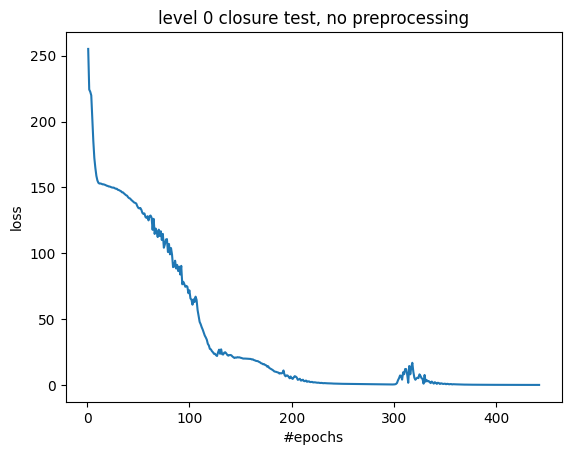

tensor(262.2781, grad_fn=<DotBackward0>)
tensor(201.7655, grad_fn=<DotBackward0>)
tensor(166.4289, grad_fn=<DotBackward0>)
tensor(150.3672, grad_fn=<DotBackward0>)
tensor(161.4991, grad_fn=<DotBackward0>)
tensor(175.5790, grad_fn=<DotBackward0>)
tensor(171.0515, grad_fn=<DotBackward0>)
tensor(159.1544, grad_fn=<DotBackward0>)
tensor(150.0718, grad_fn=<DotBackward0>)
tensor(147.6542, grad_fn=<DotBackward0>)
tensor(150.0277, grad_fn=<DotBackward0>)
tensor(153.8474, grad_fn=<DotBackward0>)
tensor(156.6626, grad_fn=<DotBackward0>)
tensor(157.4058, grad_fn=<DotBackward0>)
tensor(156.0479, grad_fn=<DotBackward0>)
tensor(153.1880, grad_fn=<DotBackward0>)
tensor(149.6913, grad_fn=<DotBackward0>)
tensor(146.8106, grad_fn=<DotBackward0>)
tensor(146.2846, grad_fn=<DotBackward0>)
tensor(146.5367, grad_fn=<DotBackward0>)
tensor(147.2539, grad_fn=<DotBackward0>)
tensor(148.0818, grad_fn=<DotBackward0>)
tensor(148.0756, grad_fn=<DotBackward0>)
tensor(147.1249, grad_fn=<DotBackward0>)
tensor(145.8159,

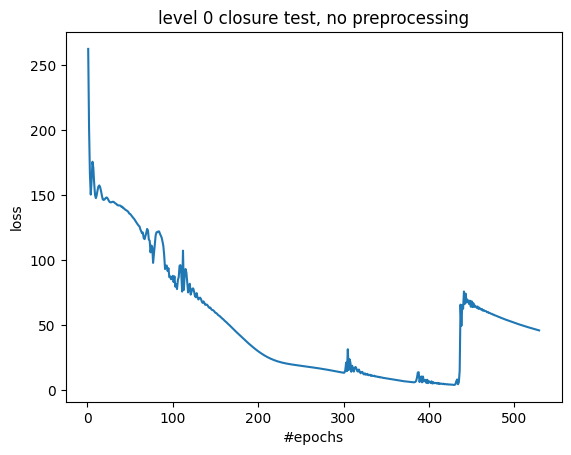

tensor(319.8795, grad_fn=<DotBackward0>)
tensor(319.2713, grad_fn=<DotBackward0>)
tensor(318.6597, grad_fn=<DotBackward0>)
tensor(318.0308, grad_fn=<DotBackward0>)
tensor(317.3806, grad_fn=<DotBackward0>)
tensor(316.7069, grad_fn=<DotBackward0>)
tensor(316.0076, grad_fn=<DotBackward0>)
tensor(315.2796, grad_fn=<DotBackward0>)
tensor(314.5192, grad_fn=<DotBackward0>)
tensor(313.7218, grad_fn=<DotBackward0>)
tensor(312.8820, grad_fn=<DotBackward0>)
tensor(311.9936, grad_fn=<DotBackward0>)
tensor(311.0497, grad_fn=<DotBackward0>)
tensor(310.0428, grad_fn=<DotBackward0>)
tensor(308.9646, grad_fn=<DotBackward0>)
tensor(307.8058, grad_fn=<DotBackward0>)
tensor(306.5553, grad_fn=<DotBackward0>)
tensor(305.1971, grad_fn=<DotBackward0>)
tensor(303.6892, grad_fn=<DotBackward0>)
tensor(300.9017, grad_fn=<DotBackward0>)
tensor(294.0770, grad_fn=<DotBackward0>)
tensor(280.0283, grad_fn=<DotBackward0>)
tensor(258.0768, grad_fn=<DotBackward0>)
tensor(225.9633, grad_fn=<DotBackward0>)
tensor(201.3958,

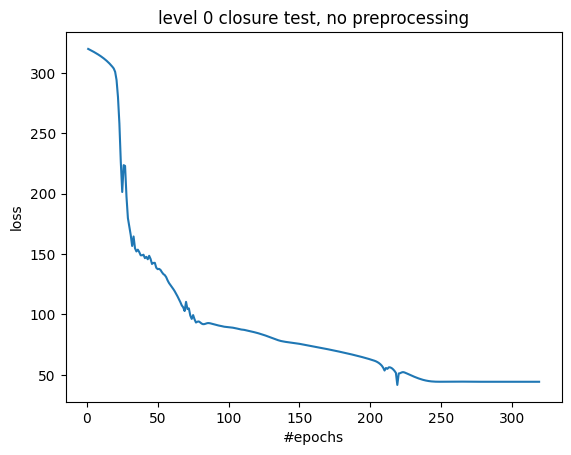

tensor(317.0645, grad_fn=<DotBackward0>)
tensor(315.4239, grad_fn=<DotBackward0>)
tensor(312.0878, grad_fn=<DotBackward0>)
tensor(307.1270, grad_fn=<DotBackward0>)
tensor(299.9586, grad_fn=<DotBackward0>)
tensor(289.4740, grad_fn=<DotBackward0>)
tensor(274.8944, grad_fn=<DotBackward0>)
tensor(255.7390, grad_fn=<DotBackward0>)
tensor(231.9288, grad_fn=<DotBackward0>)
tensor(203.9829, grad_fn=<DotBackward0>)
tensor(173.3345, grad_fn=<DotBackward0>)
tensor(143.3291, grad_fn=<DotBackward0>)
tensor(122.2108, grad_fn=<DotBackward0>)
tensor(122.2051, grad_fn=<DotBackward0>)
tensor(140.0619, grad_fn=<DotBackward0>)
tensor(153.2709, grad_fn=<DotBackward0>)
tensor(141.5383, grad_fn=<DotBackward0>)
tensor(123.1803, grad_fn=<DotBackward0>)
tensor(109.8411, grad_fn=<DotBackward0>)
tensor(102.5310, grad_fn=<DotBackward0>)
tensor(99.3795, grad_fn=<DotBackward0>)
tensor(98.3069, grad_fn=<DotBackward0>)
tensor(96.9206, grad_fn=<DotBackward0>)
tensor(93.8051, grad_fn=<DotBackward0>)
tensor(89.1245, grad

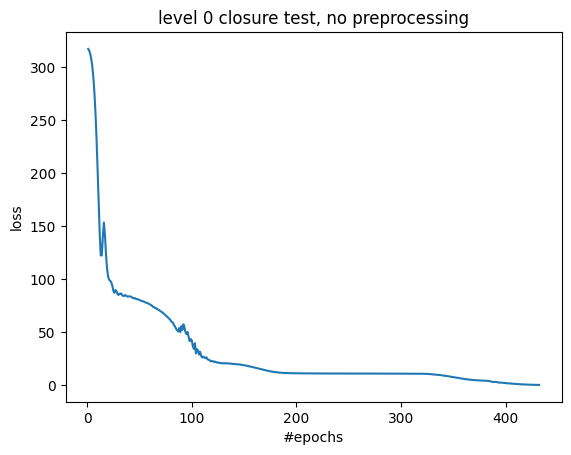

tensor(180.4964, grad_fn=<DotBackward0>)
tensor(179.6933, grad_fn=<DotBackward0>)
tensor(251.8221, grad_fn=<DotBackward0>)
tensor(176.7183, grad_fn=<DotBackward0>)
tensor(216.8090, grad_fn=<DotBackward0>)
tensor(217.8943, grad_fn=<DotBackward0>)
tensor(182.3697, grad_fn=<DotBackward0>)
tensor(165.8306, grad_fn=<DotBackward0>)
tensor(171.2156, grad_fn=<DotBackward0>)
tensor(174.0510, grad_fn=<DotBackward0>)
tensor(162.6794, grad_fn=<DotBackward0>)
tensor(145.3156, grad_fn=<DotBackward0>)
tensor(135.0207, grad_fn=<DotBackward0>)
tensor(137.4289, grad_fn=<DotBackward0>)
tensor(144.6278, grad_fn=<DotBackward0>)
tensor(142.0365, grad_fn=<DotBackward0>)
tensor(130.4388, grad_fn=<DotBackward0>)
tensor(123.5604, grad_fn=<DotBackward0>)
tensor(124.9373, grad_fn=<DotBackward0>)
tensor(127.2706, grad_fn=<DotBackward0>)
tensor(127.1857, grad_fn=<DotBackward0>)
tensor(127.8104, grad_fn=<DotBackward0>)
tensor(128.3890, grad_fn=<DotBackward0>)
tensor(127.9536, grad_fn=<DotBackward0>)
tensor(127.4534,

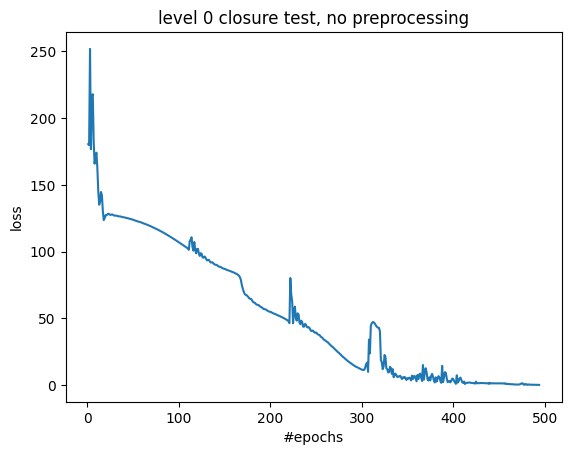

tensor(117.3225, grad_fn=<DotBackward0>)
tensor(106.6039, grad_fn=<DotBackward0>)
tensor(113.7733, grad_fn=<DotBackward0>)
tensor(107.3564, grad_fn=<DotBackward0>)
tensor(105.1713, grad_fn=<DotBackward0>)
tensor(107.6268, grad_fn=<DotBackward0>)
tensor(108.4704, grad_fn=<DotBackward0>)
tensor(106.4913, grad_fn=<DotBackward0>)
tensor(104.1105, grad_fn=<DotBackward0>)
tensor(104.0680, grad_fn=<DotBackward0>)
tensor(105.2013, grad_fn=<DotBackward0>)
tensor(105.0934, grad_fn=<DotBackward0>)
tensor(103.5038, grad_fn=<DotBackward0>)
tensor(102.6168, grad_fn=<DotBackward0>)
tensor(102.7433, grad_fn=<DotBackward0>)
tensor(102.6525, grad_fn=<DotBackward0>)
tensor(101.6895, grad_fn=<DotBackward0>)
tensor(102.4233, grad_fn=<DotBackward0>)
tensor(101.0979, grad_fn=<DotBackward0>)
tensor(101.2192, grad_fn=<DotBackward0>)
tensor(100.6174, grad_fn=<DotBackward0>)
tensor(99.8483, grad_fn=<DotBackward0>)
tensor(99.5387, grad_fn=<DotBackward0>)
tensor(98.6989, grad_fn=<DotBackward0>)
tensor(98.4561, gra

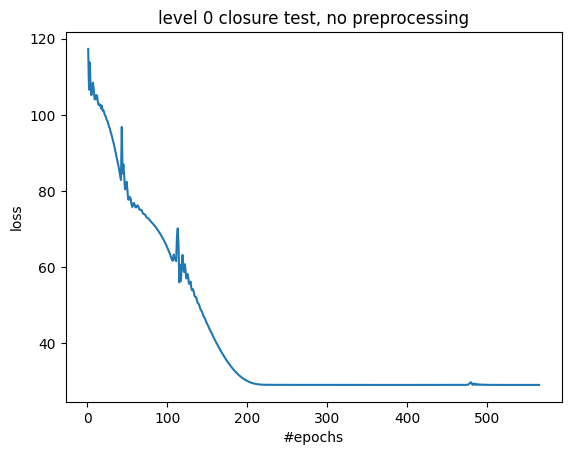

tensor(348.6658, grad_fn=<DotBackward0>)
tensor(320.6199, grad_fn=<DotBackward0>)
tensor(282.7250, grad_fn=<DotBackward0>)
tensor(238.8410, grad_fn=<DotBackward0>)
tensor(196.8451, grad_fn=<DotBackward0>)
tensor(170.0541, grad_fn=<DotBackward0>)
tensor(175.9155, grad_fn=<DotBackward0>)
tensor(199.1885, grad_fn=<DotBackward0>)
tensor(200.9887, grad_fn=<DotBackward0>)
tensor(187.8794, grad_fn=<DotBackward0>)
tensor(173.8431, grad_fn=<DotBackward0>)
tensor(166.3659, grad_fn=<DotBackward0>)
tensor(165.9539, grad_fn=<DotBackward0>)
tensor(169.4320, grad_fn=<DotBackward0>)
tensor(173.4752, grad_fn=<DotBackward0>)
tensor(176.0219, grad_fn=<DotBackward0>)
tensor(176.2591, grad_fn=<DotBackward0>)
tensor(174.2099, grad_fn=<DotBackward0>)
tensor(170.4147, grad_fn=<DotBackward0>)
tensor(165.9343, grad_fn=<DotBackward0>)
tensor(162.3727, grad_fn=<DotBackward0>)
tensor(160.1614, grad_fn=<DotBackward0>)
tensor(159.6945, grad_fn=<DotBackward0>)
tensor(160.6544, grad_fn=<DotBackward0>)
tensor(161.9472,

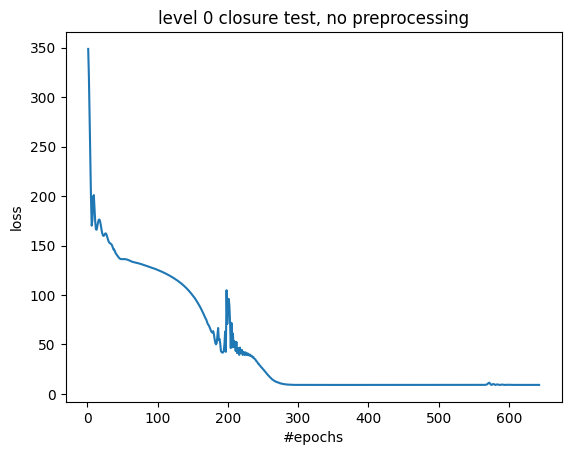

tensor(315.6186, grad_fn=<DotBackward0>)
tensor(315.3493, grad_fn=<DotBackward0>)
tensor(315.0173, grad_fn=<DotBackward0>)
tensor(314.2445, grad_fn=<DotBackward0>)
tensor(311.3792, grad_fn=<DotBackward0>)
tensor(310.8320, grad_fn=<DotBackward0>)
tensor(310.2417, grad_fn=<DotBackward0>)
tensor(309.6030, grad_fn=<DotBackward0>)
tensor(308.9200, grad_fn=<DotBackward0>)
tensor(308.1950, grad_fn=<DotBackward0>)
tensor(307.4289, grad_fn=<DotBackward0>)
tensor(306.4699, grad_fn=<DotBackward0>)
tensor(305.1742, grad_fn=<DotBackward0>)
tensor(303.5861, grad_fn=<DotBackward0>)
tensor(298.7739, grad_fn=<DotBackward0>)
tensor(289.8367, grad_fn=<DotBackward0>)
tensor(276.6177, grad_fn=<DotBackward0>)
tensor(259.0925, grad_fn=<DotBackward0>)
tensor(238.1997, grad_fn=<DotBackward0>)
tensor(217.7848, grad_fn=<DotBackward0>)
tensor(207.9833, grad_fn=<DotBackward0>)
tensor(217.0130, grad_fn=<DotBackward0>)
tensor(221.9529, grad_fn=<DotBackward0>)
tensor(215.3345, grad_fn=<DotBackward0>)
tensor(200.3030,

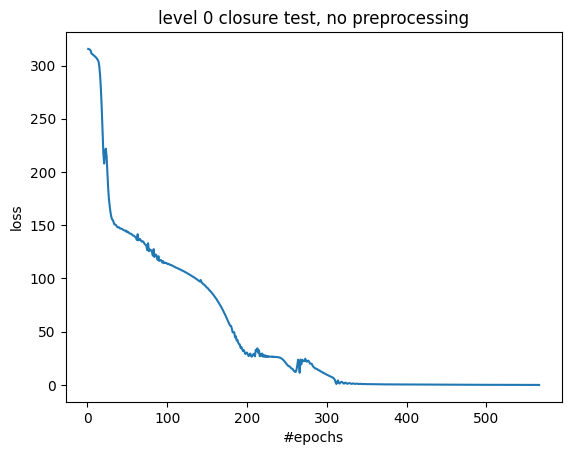

tensor(270.1317, grad_fn=<DotBackward0>)
tensor(249.5486, grad_fn=<DotBackward0>)
tensor(227.1273, grad_fn=<DotBackward0>)
tensor(209.9861, grad_fn=<DotBackward0>)
tensor(200.0386, grad_fn=<DotBackward0>)
tensor(204.2658, grad_fn=<DotBackward0>)
tensor(213.2425, grad_fn=<DotBackward0>)
tensor(211.7952, grad_fn=<DotBackward0>)
tensor(206.4018, grad_fn=<DotBackward0>)
tensor(200.6164, grad_fn=<DotBackward0>)
tensor(197.2336, grad_fn=<DotBackward0>)
tensor(196.2456, grad_fn=<DotBackward0>)
tensor(197.0822, grad_fn=<DotBackward0>)
tensor(198.0638, grad_fn=<DotBackward0>)
tensor(198.0379, grad_fn=<DotBackward0>)
tensor(196.8374, grad_fn=<DotBackward0>)
tensor(194.9624, grad_fn=<DotBackward0>)
tensor(193.1734, grad_fn=<DotBackward0>)
tensor(192.2065, grad_fn=<DotBackward0>)
tensor(192.1669, grad_fn=<DotBackward0>)
tensor(190.9432, grad_fn=<DotBackward0>)
tensor(186.5624, grad_fn=<DotBackward0>)
tensor(177.5747, grad_fn=<DotBackward0>)
tensor(164.3539, grad_fn=<DotBackward0>)
tensor(150.2152,

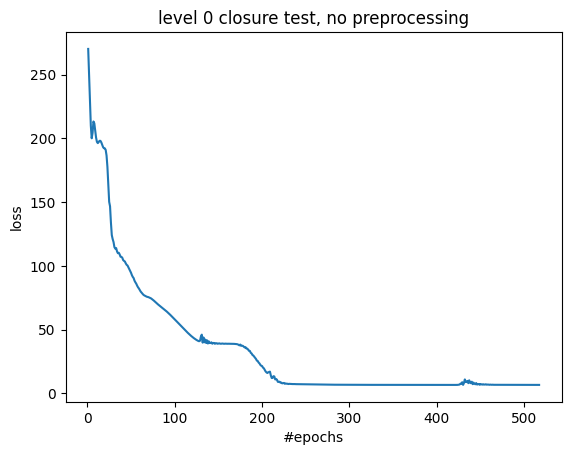

tensor(210.3794, grad_fn=<DotBackward0>)
tensor(182.1746, grad_fn=<DotBackward0>)
tensor(180.7874, grad_fn=<DotBackward0>)
tensor(171.6887, grad_fn=<DotBackward0>)
tensor(157.3436, grad_fn=<DotBackward0>)
tensor(145.6425, grad_fn=<DotBackward0>)
tensor(141.8076, grad_fn=<DotBackward0>)
tensor(144.5865, grad_fn=<DotBackward0>)
tensor(143.6876, grad_fn=<DotBackward0>)
tensor(136.2943, grad_fn=<DotBackward0>)
tensor(129.3489, grad_fn=<DotBackward0>)
tensor(127.7840, grad_fn=<DotBackward0>)
tensor(129.1370, grad_fn=<DotBackward0>)
tensor(129.6809, grad_fn=<DotBackward0>)
tensor(129.6547, grad_fn=<DotBackward0>)
tensor(129.2966, grad_fn=<DotBackward0>)
tensor(128.9344, grad_fn=<DotBackward0>)
tensor(128.7975, grad_fn=<DotBackward0>)
tensor(128.8490, grad_fn=<DotBackward0>)
tensor(128.8303, grad_fn=<DotBackward0>)
tensor(128.5285, grad_fn=<DotBackward0>)
tensor(127.9615, grad_fn=<DotBackward0>)
tensor(127.2144, grad_fn=<DotBackward0>)
tensor(126.2877, grad_fn=<DotBackward0>)
tensor(124.8038,

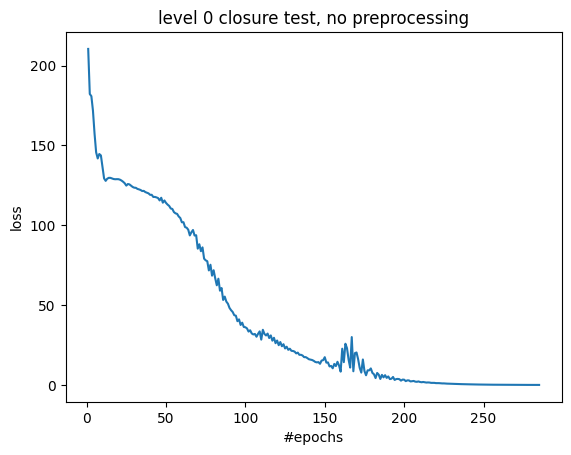

tensor(304.9908, grad_fn=<DotBackward0>)
tensor(304.2925, grad_fn=<DotBackward0>)
tensor(284.7966, grad_fn=<DotBackward0>)
tensor(257.0608, grad_fn=<DotBackward0>)
tensor(223.4067, grad_fn=<DotBackward0>)
tensor(187.3154, grad_fn=<DotBackward0>)
tensor(154.6487, grad_fn=<DotBackward0>)
tensor(136.8775, grad_fn=<DotBackward0>)
tensor(152.2694, grad_fn=<DotBackward0>)
tensor(166.8098, grad_fn=<DotBackward0>)
tensor(160.4046, grad_fn=<DotBackward0>)
tensor(147.3090, grad_fn=<DotBackward0>)
tensor(136.4192, grad_fn=<DotBackward0>)
tensor(131.9740, grad_fn=<DotBackward0>)
tensor(132.6689, grad_fn=<DotBackward0>)
tensor(135.3589, grad_fn=<DotBackward0>)
tensor(137.7852, grad_fn=<DotBackward0>)
tensor(138.7513, grad_fn=<DotBackward0>)
tensor(138.1260, grad_fn=<DotBackward0>)
tensor(136.5361, grad_fn=<DotBackward0>)
tensor(135.1484, grad_fn=<DotBackward0>)
tensor(134.1106, grad_fn=<DotBackward0>)
tensor(133.0956, grad_fn=<DotBackward0>)
tensor(132.3215, grad_fn=<DotBackward0>)
tensor(131.7785,

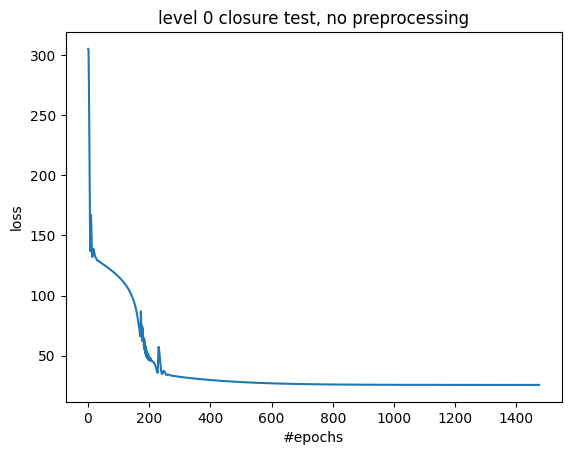

tensor(316.4617, grad_fn=<DotBackward0>)
tensor(294.0095, grad_fn=<DotBackward0>)
tensor(268.2323, grad_fn=<DotBackward0>)
tensor(248.0200, grad_fn=<DotBackward0>)
tensor(244.9099, grad_fn=<DotBackward0>)
tensor(252.9872, grad_fn=<DotBackward0>)
tensor(253.1933, grad_fn=<DotBackward0>)
tensor(247.2883, grad_fn=<DotBackward0>)
tensor(241.4314, grad_fn=<DotBackward0>)
tensor(238.4134, grad_fn=<DotBackward0>)
tensor(237.8562, grad_fn=<DotBackward0>)
tensor(238.1756, grad_fn=<DotBackward0>)
tensor(238.0542, grad_fn=<DotBackward0>)
tensor(236.8188, grad_fn=<DotBackward0>)
tensor(234.0805, grad_fn=<DotBackward0>)
tensor(227.1463, grad_fn=<DotBackward0>)
tensor(217.0348, grad_fn=<DotBackward0>)
tensor(207.5585, grad_fn=<DotBackward0>)
tensor(204.2105, grad_fn=<DotBackward0>)
tensor(198.3102, grad_fn=<DotBackward0>)
tensor(182.0273, grad_fn=<DotBackward0>)
tensor(180.2304, grad_fn=<DotBackward0>)
tensor(177.7416, grad_fn=<DotBackward0>)
tensor(171.5001, grad_fn=<DotBackward0>)
tensor(165.1908,

KeyboardInterrupt: 

In [12]:
chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model = perform_fit(pred,REPLICAS)

In [ ]:
closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

In [ ]:
x_vals = x_vals.detach().numpy().flatten()
faser_pdf_mu,x_faser = read_pdf(pdf,x_vals,14) 
faser_pdf_mub,x_faser = read_pdf(pdf,x_vals,-14)
# mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals
mean_fnu_mu = np.mean(neutrino_pdfs_mu,axis=0) 
mean_fnu_mub = np.mean(neutrino_pdfs_mub,axis=0) 

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

In [ ]:
print(mean_fnu_mub.shape)
print(mean_fnu_mu.shape)

()
()


In [ ]:
print(xvals_per_obs)

tensor([[ 125.],
        [ 375.],
        [ 750.],
        [1250.],
        [-375.],
        [-125.]])


In [ ]:
xvals_per_obs = [100.,300.,600.,1000.,-300.,-100.]
xvals_per_obs = np.array(xvals_per_obs)
xvals_per_obs /= 0.8

100,300,600,1000,300,100 

(100, 300, 600, 1000, 300, 100)

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_68051/2017845224.py:15: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axR = fig.add_subplot(gs[0, 0])
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_68051/2017845224.py:16: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axrR = fig.add_subplot(gs[1, 0])


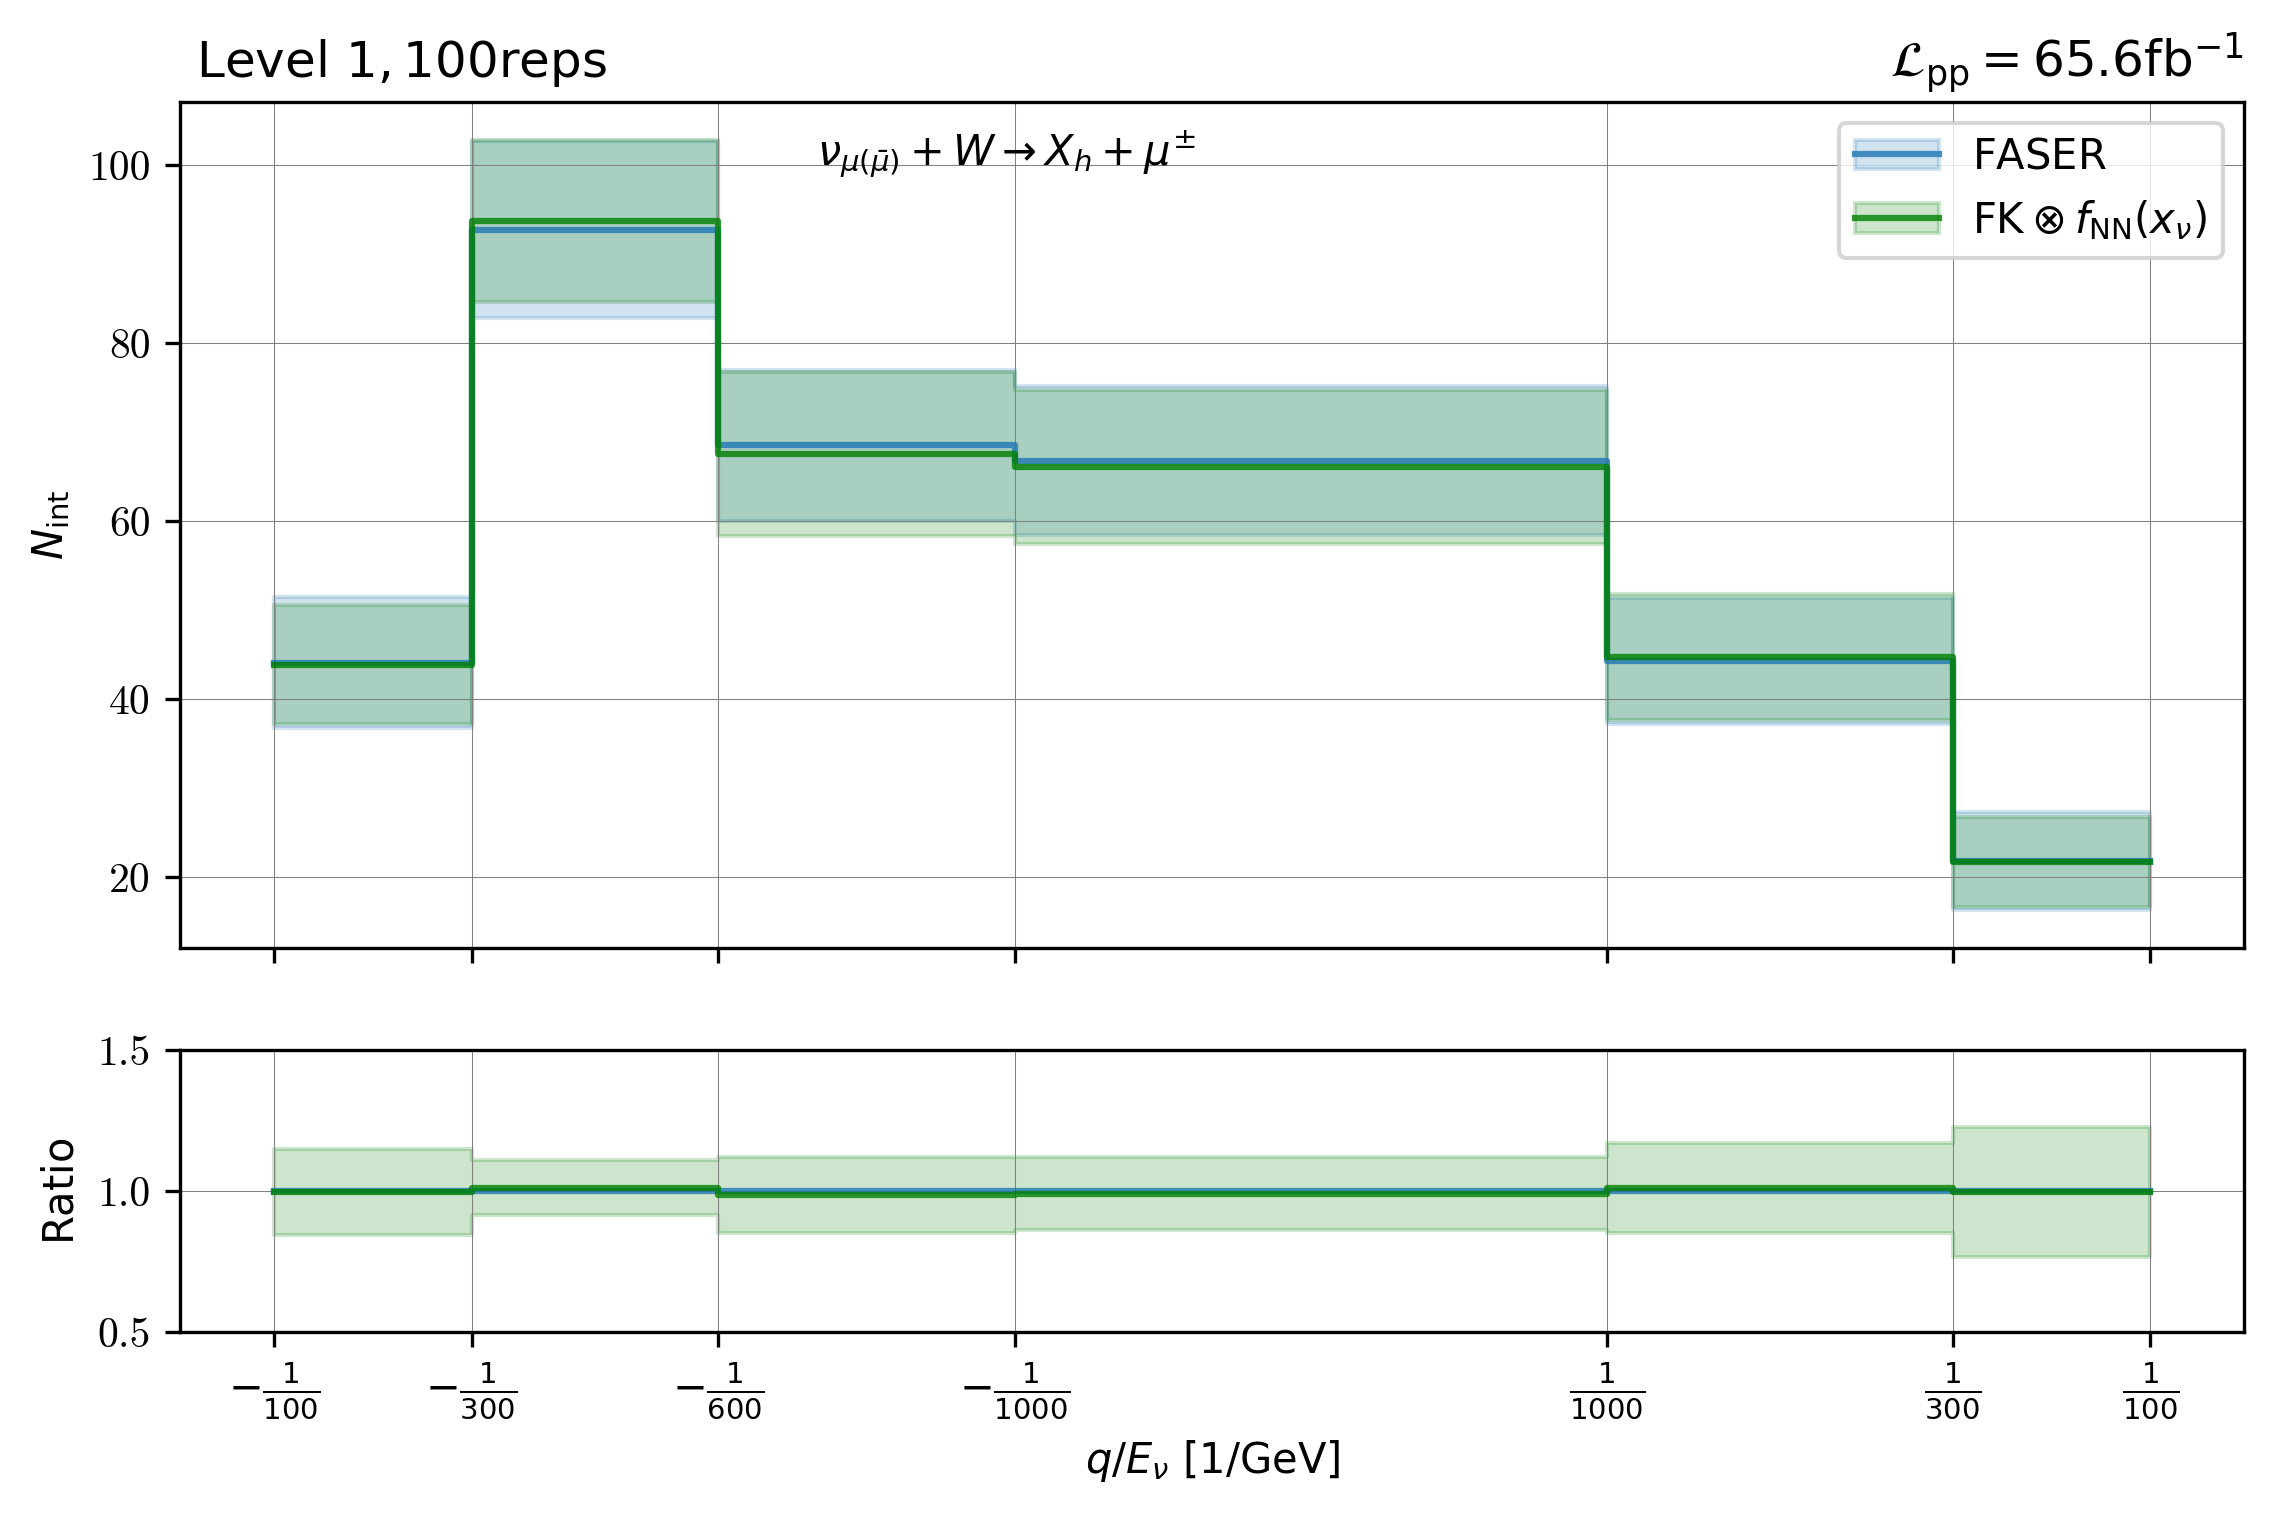

In [ ]:
from matplotlib import gridspec
from matplotlib.legend_handler import HandlerTuple

fig = plt.figure(figsize=(8, 5), dpi=300)  # 2 rows, 2 columns
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(left=0.09, right=0.95, top=0.93, hspace=0.18)

plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["cmr10"],  # Computer Modern
    }
)

axR = fig.add_subplot(gs[0, 0])
axrR = fig.add_subplot(gs[1, 0])


xvals_per_obs = [-1500, -1100, -600, 0.0, 1200, 1900, 2300]


simulated_Enu = pred
# errors_enu = [5186, 6239, 4165, 1738, 622, 847]
# errors_enu = np.array(errors_enu)
errors_enu = np.sqrt(sig_sys**2 + sig_stat**2)
simulated_Enu = level0[0]
preds_Enu = np.mean(N_event_pred, axis=0)
pred_stds_Enu = np.std(N_event_pred, axis=0)


# sorted_indices = np.argsort(xvals_per_obs)
# xvals_per_obs = xvals_per_obs[sorted_indices]
# simulated_Enu = simulated_Enu[sorted_indices]
# errors_enu = errors_enu[sorted_indices]
# preds_Enu = preds_Enu[sorted_indices]
# pred_stds_Enu = pred_stds_Enu[sorted_indices]

# print(len(sorted_indices))

# # xvals_per_obs = np.insert(xvals_per_obs, -1, xvals_per_obs[-1])
simulated_Enu = np.insert(simulated_Enu, -1, simulated_Enu[-1])
preds_Enu = np.insert(preds_Enu, -1, preds_Enu[-1])
pred_stds_Enu = np.insert(pred_stds_Enu, -1, pred_stds_Enu[-1])
errors_enu = np.insert(errors_enu, -1, errors_enu[-1])
# xvals_per_obs = [-300, -100, 100, 300, 600, 1000, 1900]
# xvals_per_obs = np.array(xvals_per_obs)

# =========== TOP RIGHT (Rates Enu vs FK otimes f_NN)

(axRsim,) = axR.plot(
    xvals_per_obs,
    simulated_Enu,
    drawstyle="steps-post",
    color="tab:blue",
    alpha=0.8,
)
axRsimerr = axR.fill_between(
    xvals_per_obs,
    simulated_Enu + errors_enu,
    simulated_Enu - errors_enu,
    step="post",
    color="tab:blue",
    alpha=0.2,
    label=r"POWHEG $E_\nu$",
)

(axRpred,) = axR.plot(
    xvals_per_obs,
    preds_Enu,
    color="green",
    drawstyle="steps-post",
    alpha=0.8,
    label=r"$\mathrm{NN}(E_\nu)$",
)
axRprederr = axR.fill_between(
    xvals_per_obs,
    (preds_Enu + pred_stds_Enu),
    (preds_Enu - pred_stds_Enu),
    color="green",
    alpha=0.2,
    step="post",
    label=r"$\pm 1\sigma$",
)
axR.legend(
    [(axRsimerr, axRsim), (axRprederr, axRpred)],
    [
        r"$\mathrm{FASER}$",
        r"$\mathrm{FK} \otimes f_{\mathrm{NN}}(x_\nu)$",
        # r"$\mathcal{A}_{\mathcal{fit}} \ \cdot \ N_{\mathrm{int}}(E_\nu)$",
    ],
    handler_map={tuple: HandlerTuple(ndivide=1)},
    loc="upper right",
).set_alpha(0.8)
# axR.set_xlim(0)
# axR.set_ylim(0)
tick_labels = [
    r"$-\frac{1}{100}$",
    r"$-\frac{1}{300}$",
    r"$-\frac{1}{600}$",
    r"$-\frac{1}{1000}$",
    r"$\frac{1}{1000}$",
    r"$\frac{1}{300}$",
    r"$\frac{1}{100}$",
]

# Use `xvals_per_obs` positions for labels
axR.set_xticks(xvals_per_obs)
axR.set_xticklabels(tick_labels)

axR.grid(color="grey", linestyle="-", linewidth=0.25)
axR.set_xticklabels([])
axR.set_title(r"$\mathcal{L}_{\mathrm{pp}} = 65.6 \mathrm{fb}^{-1}$", loc="right")
axR.set_title(r"$\ \mathrm{Level\ 1},100 \mathrm{reps}$", loc="left")
axR.text(-400, 100, r"$\nu_{\mu(\bar{\mu})} + W \rightarrow X_h+  \mu^{\pm} $")
axR.set_ylabel(r"$N_{\mathrm{int}}$")

ratio_center_pred = preds_Enu / simulated_Enu
ratio_lower_pred = (preds_Enu - pred_stds_Enu) / simulated_Enu
ratio_upper_pred = (preds_Enu + pred_stds_Enu) / simulated_Enu
ratio_upper_sim = (simulated_Enu + errors_enu) / simulated_Enu
ratio_lower_sim = (simulated_Enu + errors_enu) / simulated_Enu

axrR.fill_between(
    xvals_per_obs, ratio_upper_sim, ratio_lower_sim, step="post", alpha=0.2
)
axrR.plot(xvals_per_obs, np.ones(len(simulated_Enu)), drawstyle="steps-post", alpha=0.8)

axrR.fill_between(
    xvals_per_obs,
    ratio_upper_pred,
    ratio_lower_pred,
    step="post",
    alpha=0.2,
    color="green",
)
axrR.plot(
    xvals_per_obs,
    ratio_center_pred,
    drawstyle="steps-post",
    alpha=0.8,
    color="green",
)

axrR.set_ylabel(r"$\mathrm{Ratio}$")
axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")
axrR.set_ylim(0.5, 1.5)
# axrR.set_xlim(0)
axrR.grid(color="grey", linestyle="-", linewidth=0.25)

tick_labels = [
    r"$-\frac{1}{100}$",
    r"$-\frac{1}{300}$",
    r"$-\frac{1}{600}$",
    r"$-\frac{1}{1000}$",
    r"$\frac{1}{1000}$",
    r"$\frac{1}{300}$",
    r"$\frac{1}{100}$",
]

# Use `xvals_per_obs` positions for labels
axrR.set_xticks(xvals_per_obs)
axrR.set_xticklabels(tick_labels)

axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")
plt.savefig("no_FK_ML_faserdat.pdf")
plt.show()


In [ ]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from read_faserv_pdf import read_pdf
# Data for plot


def plots(x_vals, neutrino_pdfs, level0, N_event_pred, sig_tot, xvals_per_obs, pid):
    pdf = "faserv"
    faser_pdf, x_faser = read_pdf(pdf, x_vals, pid)
    mean_fnu = np.mean(neutrino_pdfs, axis=0)
    error_fnu = np.std(neutrino_pdfs, axis=0)

    simulated_Enu = level0[0]
    preds_Enu = np.mean(N_event_pred, axis=0)
    pred_stds_Enu = np.std(N_event_pred, axis=0)
    # errors_enu = [5186, 6239, 4165, 1738, 622, 847]
    # errors_enu = np.array(errors_enu)
    # errors_enu = np.sqrt(level0[0])
    errors_enu = sig_tot

    xvals_per_obs = np.append(xvals_per_obs, 1900)
    simulated_Enu = np.append(simulated_Enu, simulated_Enu[-1])
    print(simulated_Enu)
    preds_Enu = np.append(preds_Enu, preds_Enu[-1])
    print(preds_Enu)
    pred_stds_Enu = np.append(pred_stds_Enu, pred_stds_Enu[-1])
    errors_enu = np.append(errors_enu, errors_enu[-1])
    fig = plt.figure(figsize=(6.8, 3.4), dpi=300)  # 2 rows, 2 columns
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])
    gs.update(left=0.09, right=0.95, top=0.93, hspace=0.18)

    axL = fig.add_subplot(gs[0, 0])
    axR = fig.add_subplot(gs[0, 1])
    axrL = fig.add_subplot(gs[1, 0])
    axrR = fig.add_subplot(gs[1, 1])

    # =========== TOP RIGHT (Rates Enu vs FK otimes f_NN)

    sorted_indices = np.argsort(xvals_per_obs)
    xvals_per_obs = xvals_per_obs[sorted_indices]
    simulated_Enu = simulated_Enu[sorted_indices]
    errors_enu = errors_enu[sorted_indices]
    preds_Enu = preds_Enu[sorted_indices]
    pred_stds_Enu = pred_stds_Enu[sorted_indices]

    (axRsim,) = axR.plot(
        xvals_per_obs,
        simulated_Enu,
        drawstyle="steps-post",
        color="tab:blue",
        alpha=0.8,
    )
    axRsimerr = axR.fill_between(
        xvals_per_obs,
        simulated_Enu + errors_enu,
        simulated_Enu - errors_enu,
        step="post",
        color="tab:blue",
        alpha=0.2,
        label=r"POWHEG $E_\nu$",
    )

    (axRpred,) = axR.plot(
        xvals_per_obs,
        preds_Enu,
        color="red",
        drawstyle="steps-post",
        alpha=0.8,
        label=r"$\mathrm{NN}(E_\nu)$",
    )
    axRprederr = axR.fill_between(
        xvals_per_obs,
        (preds_Enu + pred_stds_Enu),
        (preds_Enu - pred_stds_Enu),
        color="red",
        alpha=0.2,
        step="post",
        label=r"$\pm 1\sigma$",
    )
    axR.legend(
        [(axRsimerr, axRsim), (axRprederr, axRpred)],
        [
            r"$\mathrm{NLO+PS} \ E_\nu$",
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{NN}}(x_\nu)$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="upper right",
    ).set_alpha(0.8)
    # axR.set_xlim(0)
    # axR.set_ylim(0)
    axR.grid(color="grey", linestyle="-", linewidth=0.25)
    # axR.set_xticklabels([-100,100])
    axR.set_title(r"$\mathcal{L}_{\mathrm{pp}} = 150 \mathrm{fb}^{-1}$", loc="right")
    axR.set_title(r"$\mathrm{FASER}\nu, \ \mathrm{Level\ 2}$", loc="left")
    # axR.text(800, 400, r"$\nu_e W \rightarrow X_h e^- $")
    axR.set_ylabel(r"$N_{\mathrm{int}}$")

    ratio_center_pred = preds_Enu / simulated_Enu
    ratio_lower_pred = (preds_Enu - pred_stds_Enu) / simulated_Enu
    ratio_upper_pred = (preds_Enu + pred_stds_Enu) / simulated_Enu
    ratio_upper_sim = (simulated_Enu + errors_enu) / simulated_Enu
    ratio_lower_sim = (simulated_Enu - errors_enu) / simulated_Enu

    axrR.fill_between(
        xvals_per_obs, ratio_upper_sim, ratio_lower_sim, step="post", alpha=0.2
    )
    axrR.plot(
        xvals_per_obs, np.ones(len(simulated_Enu)), drawstyle="steps-post", alpha=0.8
    )

    axrR.fill_between(
        xvals_per_obs,
        ratio_upper_pred,
        ratio_lower_pred,
        step="post",
        alpha=0.2,
        color="red",
    )
    axrR.plot(
        xvals_per_obs, ratio_center_pred, drawstyle="steps-post", alpha=0.8, color="red"
    )
    axR.set_xlim(min(xvals_per_obs), max(xvals_per_obs))
    axrR.set_xlim(min(xvals_per_obs), max(xvals_per_obs))

    axrR.set_ylabel(r"$\mathrm{Ratio}$")
    axrR.set_xlabel(r"$E_\nu \ [\mathrm{GeV}]$")
    axrR.set_ylim(0.5, 1.5)
    # axrR.set_xlim(0)
    axrR.grid(color="grey", linestyle="-", linewidth=0.25)

    fig.show()


In [ ]:
from plot_results import plot
# sig_tot = np.sqrt(sig_sys+sig_stat)
sig_tot = 1/np.sqrt(np.diag(cov_matrix)) 
print(sig_tot)
# plots(x_vals, neutrino_pdfs_mu, level0, N_event_pred, sig_tot, xvals_per_obs,14)
# plots(x_vals, neutrino_pdfs_mub, level0, N_event_pred, sig_tot, xvals_per_obs,-14)

[7.3287106 9.947361  8.449261  8.328265  7.042017  5.5054517]


In [ ]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs.flatten())
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

AttributeError: 'list' object has no attribute 'flatten'

In [ ]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
# x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo